In [293]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd
import skforecast

print(skforecast.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/joaquin/Documents/GitHub/skforecast
0.19.1


In [294]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import skforecast
from skforecast.stats import Sarimax, Arima
from skforecast.recursive import ForecasterStats
from skforecast.model_selection import TimeSeriesFold, backtesting_stats
from skforecast.plot import set_dark_theme
from skforecast.datasets import fetch_dataset

from aeon.forecasting.stats import ARIMA as ARIMA_aeon
from statsforecast import StatsForecast
from statsforecast.models import ARIMA as ARIMA_statsforecast
import matplotlib.pyplot as plt
import timeit

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
print(f"skforecast version: {skforecast.__version__}")

skforecast version: 0.19.1


In [295]:
# Download data
# ==============================================================================
data = fetch_dataset(name='fuel_consumption', raw=True, verbose=False)
data = data[['Fecha', 'Gasolinas']]
data = data.rename(columns={'Fecha': 'date', 'Gasolinas': 'y'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.loc[:'1990-01-01 00:00:00', ['y']]
data['month'] = data.index.month
data = pd.get_dummies(data, columns=['month'], prefix='month', drop_first=False, dtype=float)
data.head(3)

KeyboardInterrupt: 

In [ ]:
# Download data
# ==============================================================================
# from pmdarima.datasets import load_airpassengers
# y = load_airpassengers(as_series=True)
# data = pd.DataFrame(y.to_numpy(), columns=['y'], index=pd.date_range(start='1949-01-01', periods=len(y), freq='MS'))
# data

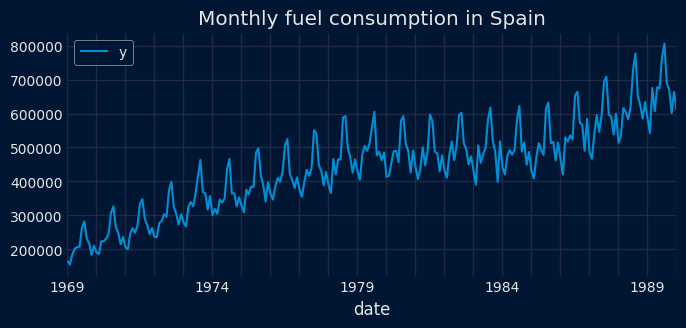

In [ ]:
# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data['y'].plot(ax=ax)
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

# Compare ets from skforecast, aeon, statsforecast and statsmodels

In [ ]:
order = (1, 1, 1)
seasonal_order = (1, 1, 1)  # Non-seasonal for fair comparison
m = 12
steps = 12

In [ ]:
# ARIMA skforecast
# ==============================================================================
estimator = Arima(
    order=order,
    seasonal_order=seasonal_order,
    m = m
)
start = timeit.default_timer()
estimator.fit(y=data['y'].to_numpy())
end = timeit.default_timer()
time_fit_arima_skforecast = end - start
print(f"Training time ARIMA skforecast  : {time_fit_arima_skforecast} seconds")
start = timeit.default_timer()
predictions_skforecast = estimator.predict(steps=steps)
end = timeit.default_timer()
time_pred_arima_skforecast = end - start
print(f"Prediction time ARIMA skforecast: {time_pred_arima_skforecast} seconds")

Training time ARIMA skforecast  : 0.664397972000188 seconds
Prediction time ARIMA skforecast: 0.0001823009997679037 seconds


/home/joaquin/Documents/GitHub/skforecast/skforecast/stats/arima/_arima_base.py:2476: UserWarning: Possible convergence problem
  warnings.warn("Possible convergence problem")


In [ ]:
# ARIMA statsmodels
# ==============================================================================
# Note: statsmodels requires seasonal_periods > 1 if seasonal components are non-zero
# So we adjust the seasonal_order for statsmodels when m=1
statsmodels_seasonal = (*seasonal_order, 0 if m==1 else m) if any(seasonal_order) else (0, 0, 0, 0)
if m == 1 and any(seasonal_order):
    print("Warning: statsmodels doesn't support seasonal components with m=1, using non-seasonal model")
    statsmodels_seasonal = (0, 0, 0, 0)

estimator = Sarimax(
    order=order,
    seasonal_order=statsmodels_seasonal,
)
start = timeit.default_timer()
estimator.fit(y=data['y'].to_numpy())
end = timeit.default_timer()
time_fit_arima_statsmodels = end - start
print(f"Training time ARIMA statsmodels  : {time_fit_arima_statsmodels} seconds")
start = timeit.default_timer()
predictions_statsmodels = estimator.predict(steps=steps)
end = timeit.default_timer()
time_pred_arima_statsmodels = end - start
print(f"Prediction time ARIMA statsmodels: {time_pred_arima_statsmodels} seconds")

Training time ARIMA statsmodels  : 0.44813770099972317 seconds
Prediction time ARIMA statsmodels: 0.0022921199997654185 seconds


In [ ]:
# ARIMA aeon
# ==============================================================================
# Aeeon ARIMA do not support seasonality nor prediction intervals
estimator=ARIMA_aeon(p=order[0], d=order[1], q=order[2])
start = timeit.default_timer()
estimator.fit(y=data['y'].to_numpy())
end = timeit.default_timer()
time_fit_arima_aeon = end - start
print(f"Training time ARIMA aeon  : {time_fit_arima_aeon} seconds")
start = timeit.default_timer()
predictions_aeon = estimator.iterative_forecast(y=data['y'].to_numpy(), prediction_horizon=steps)
end = timeit.default_timer()
time_pred_arima_aeon = end - start
print(f"Prediction time ARIMA aeon: {time_pred_arima_aeon} seconds")

Training time ARIMA aeon  : 0.0007630180007254239 seconds
Prediction time ARIMA aeon: 0.000995299000351224 seconds


In [ ]:
# Nixtla StatsForecast Arima
# ==============================================================================
df_nixtla = data['y'].reset_index()
df_nixtla.columns = ['ds', 'y']
df_nixtla['unique_id'] = 'fuel'

start = timeit.default_timer()
sf = StatsForecast(
    models=[ARIMA_statsforecast(order=order, seasonal_order=seasonal_order, season_length=m)],
    freq='MS'
)
sf.fit(df=df_nixtla)
end = timeit.default_timer()
time_fit_arima_nixtla = end - start
print(f"Training time ARIMA nixtla  : {time_fit_arima_nixtla} seconds")

start = timeit.default_timer()
predictions_nixtla_df = sf.predict(h=steps, level=[95])
end = timeit.default_timer()
time_pred_arima_nixtla = end - start

# Extract predictions and prediction intervals
predictions_nixtla = pd.Series(
    predictions_nixtla_df['ARIMA'].values,
    index=pd.date_range(start=data.index[-1] + pd.DateOffset(months=1),periods=steps, freq='MS')
)
print(f"Prediction time ARIMA nixtla: {time_pred_arima_nixtla} seconds")

Training time ARIMA nixtla  : 0.09443921899946872 seconds
Prediction time ARIMA nixtla: 0.004016882000541955 seconds


In [ ]:
# Table of times
# ==============================================================================
times_arima = pd.DataFrame({
    'fit_time_seconds': [time_fit_arima_skforecast, time_fit_arima_aeon, time_fit_arima_nixtla, time_fit_arima_statsmodels],
    'predict_time_seconds': [time_pred_arima_skforecast, time_pred_arima_aeon, time_pred_arima_nixtla, time_pred_arima_statsmodels]
}, index=['ARIMA skforecast', 'ARIMA aeon', 'ARIMA nixtla', 'ARIMA statsmodels'])
times_arima.sort_values(by='fit_time_seconds')

,fit_time_seconds,predict_time_seconds
ARIMA aeon,0.000763,0.000995
ARIMA nixtla,0.094439,0.004017
ARIMA statsmodels,0.448138,0.002292
ARIMA skforecast,0.664398,0.000182


,skforecast,aeon,nixtla,statsmodels
1990-02-01,581320.570188,620209.757283,587339.778976,582538.228180
1990-03-01,692794.257276,620209.757283,677718.699756,686073.650049
1990-04-01,655569.575021,620209.757283,672433.221254,661941.440688


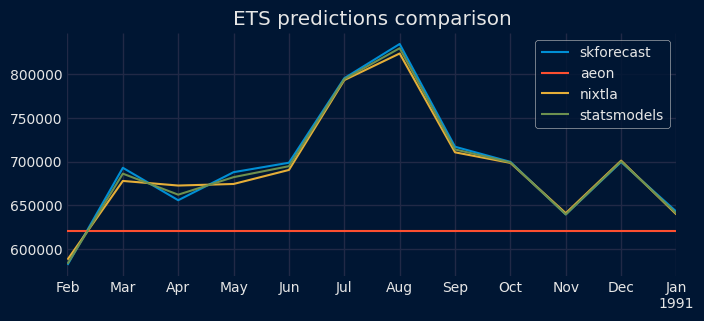

In [ ]:
# compare predictions
# ======================================================================================
predictions = pd.DataFrame({
    'skforecast': predictions_skforecast,
    'aeon'      : predictions_aeon,
    'nixtla'    : predictions_nixtla,
    'statsmodels': predictions_statsmodels
})
display(predictions.head(3))
predictions.plot(figsize=(7, 3), title='ETS predictions comparison');